In [4]:
import re
import tarfile
from pathlib import Path
import pandas as pd
import shutil
import os
import json
from collections import defaultdict
import numpy as np
from typing import Dict, List, Any, Tuple
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [7]:
# directory= '14-3-2024_#15_INDIVIDUAL_(18)' #10 chunks
directory= '8-5-2024_#18_INDIVIDUAL_[12]'     #7 chunks 

BASE_PATH = f"/home/liubov/Bureau/new/{directory}/PosesDir"
base_path = Path(BASE_PATH)

id = 2

In [8]:
file_path = f'{base_path}/new_jsons_merged_id_{id}.json'
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

In [9]:
print(f'Data: {len(data)} records')
all_keys = set()
for item in data:
    all_keys.update(item.keys())
print("Keys:")
for key in sorted(all_keys):
    print(key)

Data: 11785 records
Keys:
face_keypoints_2d
hand_left_keypoints_2d
hand_right_keypoints_2d
pose_keypoints_2d


In [10]:
def load_keypoint_data(file_path: str) -> List[Dict]:
    """Load JSON keypoint data with error handling."""

    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print(f" Loaded {len(data)} samples from {Path(file_path).name}")
    return data
   

def discover_keypoint_types(data: List[Dict]) -> List[str]:
    """Discover all keypoint types in the dataset."""
    all_keys = set()
    for item in data:
        all_keys.update(item.keys())
    
    keypoint_keys = [key for key in all_keys if 'keypoint' in key.lower()]
    print(f"Discovered keypoint types: {keypoint_keys}")
    return sorted(keypoint_keys)

def analyze_data_structure(data: List[Dict], keypoint_types: List[str]) -> Dict[str, Any]:
    """Comprehensive analysis of data structure."""
    if not data:
        return {}
        
    analysis = {
        'total_samples': len(data),
        'keypoint_types': {},
        'sample_completeness': defaultdict(int)
    }
    
    for keypoint_type in keypoint_types:
        type_analysis = {
            'present_in_samples': 0,
            'total_keypoints': 0,
            'keypoints_per_sample': [],
            'has_confidence': False,
            'coordinates_dimension': None
        }
        
        for sample in data:
            if keypoint_type in sample and sample[keypoint_type]:
                type_analysis['present_in_samples'] += 1
                kpts = np.array(sample[keypoint_type])
                
                if kpts.size > 0:
                    # Determine coordinate dimension
                    coords_per_point = 3 if len(kpts) % 3 == 0 else 2
                    if type_analysis['coordinates_dimension'] is None:
                        type_analysis['coordinates_dimension'] = coords_per_point
                    
                    n_points = len(kpts) // coords_per_point
                    type_analysis['keypoints_per_sample'].append(n_points)
                    type_analysis['total_keypoints'] += n_points
                    
                    if coords_per_point == 3:
                        type_analysis['has_confidence'] = True
        
        analysis['keypoint_types'][keypoint_type] = type_analysis
    
    # Analyze sample completeness
    for sample in data:
        present_types = sum(1 for kt in keypoint_types if kt in sample and sample[kt])
        analysis['sample_completeness'][present_types] += 1
    
    return analysis

def print_data_summary(data: List[Dict], keypoint_types: List[str]):
    """Print comprehensive data summary."""
    analysis = analyze_data_structure(data, keypoint_types)
    
    print("\n" + "="*80)
    print(" DATA STRUCTURE ANALYSIS")
    print("="*80)
    print(f"Total samples: {analysis['total_samples']}")
    print(f"Keypoint types: {len(keypoint_types)}")
    
    print("\n KEYPOINT TYPE DETAILS:")
    for ktype, details in analysis['keypoint_types'].items():
        print(f"\n  {ktype}:")
        print(f"    Present in: {details['present_in_samples']}/{analysis['total_samples']} samples "
              f"({details['present_in_samples']/analysis['total_samples']*100:.1f}%)")
        print(f"    Coordinate dimension: {details['coordinates_dimension']}D")
        print(f"    Has confidence scores: {details['has_confidence']}")
        
        if details['keypoints_per_sample']:
            kps = details['keypoints_per_sample']
            print(f"    Keypoints per sample: min={min(kps)}, max={max(kps)}, avg={np.mean(kps):.1f}")
            print(f"    Total keypoints: {details['total_keypoints']}")
    
    print("\n SAMPLE COMPLETENESS:")
    for n_types, count in sorted(analysis['sample_completeness'].items()):
        percentage = count / analysis['total_samples'] * 100
        print(f"    {n_types} keypoint types present: {count} samples ({percentage:.1f}%)")

def extract_keypoints_as_array(data: List[Dict], keypoint_type: str) -> Tuple[List[np.ndarray], List[int]]:
    """Extract keypoints with sample indices."""
    keypoints_list = []
    valid_indices = []
    
    for i, sample in enumerate(data):
        if keypoint_type in sample and sample[keypoint_type]:
            kpts = np.array(sample[keypoint_type])
            if kpts.size > 0:
                coords_per_point = 3 if len(kpts) % 3 == 0 else 2
                keypoints_list.append(kpts.reshape(-1, coords_per_point))
                valid_indices.append(i)
    
    return keypoints_list, valid_indices

def calculate_keypoint_stats(keypoints_list: List[np.ndarray]) -> Dict[str, Any]:
    """Calculate comprehensive statistics."""
    if not keypoints_list:
        return {'n_samples': 0, 'n_keypoints': 0}
    
    all_keypoints = np.concatenate(keypoints_list, axis=0)
    x_coords, y_coords = all_keypoints[:, 0], all_keypoints[:, 1]
    
    stats = {
        'n_samples': len(keypoints_list),
        'total_keypoints': all_keypoints.shape[0],
        'avg_keypoints_per_sample': all_keypoints.shape[0] / len(keypoints_list),
        'x_stats': {
            'min': float(np.min(x_coords)),
            'max': float(np.max(x_coords)),
            'mean': float(np.mean(x_coords)),
            'std': float(np.std(x_coords))
        },
        'y_stats': {
            'min': float(np.min(y_coords)),
            'max': float(np.max(y_coords)),
            'mean': float(np.mean(y_coords)),
            'std': float(np.std(y_coords))
        }
    }
    
    if all_keypoints.shape[-1] == 3:
        confidence = all_keypoints[:, 2]
        stats['confidence_stats'] = {
            'mean': float(np.mean(confidence)),
            'std': float(np.std(confidence)),
            'min': float(np.min(confidence)),
            'max': float(np.max(confidence)),
            'low_confidence_ratio': float(np.mean(confidence < 0.5))
        }
    
    return stats

def visualize_keypoint_samples(data: List[Dict], keypoint_types: List[str], 
                             sample_indices: List[int] = [0, 1, 2, 3]):
    """Create sample visualization for specific keypoint types."""
    n_types = len(keypoint_types)
    n_samples = len(sample_indices)
    
    fig, axes = plt.subplots(n_types, n_samples, figsize=(5 * n_samples, 5 * n_types))
    
    # Handle single row or column cases
    if n_types == 1:
        axes = axes.reshape(1, -1) if n_samples > 1 else [[axes]]
    elif n_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for i, ktype in enumerate(keypoint_types):
        keypoints_list, valid_indices = extract_keypoints_as_array(data, ktype)
        
        for j, sample_idx in enumerate(sample_indices):
            ax = axes[i][j] if n_types > 1 or n_samples > 1 else axes
            
            if sample_idx < len(keypoints_list):
                sample_kpts = keypoints_list[sample_idx]
                original_idx = valid_indices[sample_idx]
                
                if sample_kpts.shape[-1] == 3:
                    # Color by confidence
                    scatter = ax.scatter(sample_kpts[:, 0], sample_kpts[:, 1], 
                                       c=sample_kpts[:, 2], cmap='viridis', 
                                       alpha=0.7, s=30)
                    plt.colorbar(scatter, ax=ax, label='Confidence')
                else:
                    ax.scatter(sample_kpts[:, 0], sample_kpts[:, 1], 
                              alpha=0.7, s=30, c='blue')
                
                ax.set_title(f'{ktype}\nSample {original_idx} ({len(sample_kpts)} points)')
                ax.set_xlabel('X coordinate')
                ax.set_ylabel('Y coordinate')
                ax.grid(True, alpha=0.3)
                
                # Invert y-axis for image coordinates
                ax.invert_yaxis()
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{ktype}\nSample {sample_idx} (no data)')
    
    plt.tight_layout()
    plt.show()

def print_keypoint_statistics(data: List[Dict], keypoint_types: List[str]):
    """Print detailed keypoint statistics."""
    print("\n" + "="*60)
    print(" KEYPOINT STATISTICS")
    print("="*60)
    
    for ktype in keypoint_types:
        keypoints_list, _ = extract_keypoints_as_array(data, ktype)
        if keypoints_list:
            stats = calculate_keypoint_stats(keypoints_list)
            print(f"\n{ktype}:")
            print(f"  Samples with data: {stats['n_samples']}")
            print(f"  Total keypoints: {stats['total_keypoints']}")
            print(f"  Avg keypoints/sample: {stats['avg_keypoints_per_sample']:.1f}")
            print(f"  X range: {stats['x_stats']['min']:.1f} to {stats['x_stats']['max']:.1f}")
            print(f"  Y range: {stats['y_stats']['min']:.1f} to {stats['y_stats']['max']:.1f}")
            
            if 'confidence_stats' in stats:
                conf = stats['confidence_stats']
                print(f"  Confidence: {conf['mean']:.3f} ± {conf['std']:.3f}")
                print(f"  Low confidence ratio: {conf['low_confidence_ratio']:.2%}")

def create_distribution_plots(data: List[Dict], keypoint_types: List[str]):
    """Create distribution analysis plots."""
    n_types = len(keypoint_types)
    fig, axes = plt.subplots(n_types, 3, figsize=(18, 5 * n_types))
    
    if n_types == 1:
        axes = axes.reshape(1, -1)
    
    for i, ktype in enumerate(keypoint_types):
        keypoints_list, _ = extract_keypoints_as_array(data, ktype)
        
        if not keypoints_list:
            continue
        
        all_keypoints = np.concatenate(keypoints_list, axis=0)
        
        # X distribution
        axes[i, 0].hist(all_keypoints[:, 0], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i, 0].set_title(f'{ktype} - X Coordinate Distribution')
        axes[i, 0].set_xlabel('X coordinate')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Y distribution
        axes[i, 1].hist(all_keypoints[:, 1], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[i, 1].set_title(f'{ktype} - Y Coordinate Distribution')
        axes[i, 1].set_xlabel('Y coordinate')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Confidence distribution (if available)
        if all_keypoints.shape[-1] == 3:
            axes[i, 2].hist(all_keypoints[:, 2], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
            axes[i, 2].set_title(f'{ktype} - Confidence Distribution')
            axes[i, 2].set_xlabel('Confidence score')
            axes[i, 2].set_ylabel('Frequency')
            axes[i, 2].axvline(x=0.5, color='red', linestyle='--', label='Low confidence threshold')
            axes[i, 2].legend()
        else:
            axes[i, 2].text(0.5, 0.5, 'No confidence\ndata available', 
                           ha='center', va='center', transform=axes[i, 2].transAxes, 
                           fontsize=12)
            axes[i, 2].set_title(f'{ktype} - Confidence Distribution')
        
        axes[i, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Main analysis function
def analyze_keypoint_data(directory: str, id_val: str):
    """
    Main function to analyze keypoint data.
    
    Args:
        directory: Directory name
        id_val: ID value for the file
    """
    file_path = f'{base_path}/new_jsons_merged_id_{id}.json'
    
    # Load data
    data = load_keypoint_data(file_path)
    
    # Discover keypoint types
    keypoint_types = discover_keypoint_types(data)
    
    # Print comprehensive summary
    print_data_summary(data, keypoint_types)
    
    # Create visualizations (focus on pose keypoints by default)
    pose_types = [kt for kt in keypoint_types if 'pose' in kt.lower()]
    if not pose_types:
        pose_types = keypoint_types[:1]  # Use first available type
       
    # Print statistics
    print_keypoint_statistics(data, pose_types)
    
    return data


# Individual function usage examples:
def quick_analysis(data: List[Dict], keypoint_type: str = 'pose_keypoints_2d', 
                  sample_indices: List[int] = [0, 1, 2, 3]):
    """Quick analysis for a specific keypoint type."""
    print(f"Quick analysis for {keypoint_type}:")
    
    keypoints_list, valid_indices = extract_keypoints_as_array(data, keypoint_type)
    stats = calculate_keypoint_stats(keypoints_list)
    
    print(f"Found {len(keypoints_list)} samples with {keypoint_type} data")
    print(f"Total keypoints: {stats.get('total_keypoints', 0)}")
    print(f"Average per sample: {stats.get('avg_keypoints_per_sample', 0):.1f}")
    
    # Create quick visualization
    visualize_keypoint_samples(data, [keypoint_type], sample_indices)
    
    return keypoints_list, stats

In [11]:
data = analyze_keypoint_data(directory=directory, id_val=f'{id}')

 Loaded 11785 samples from new_jsons_merged_id_2.json
Discovered keypoint types: ['pose_keypoints_2d', 'face_keypoints_2d', 'hand_right_keypoints_2d', 'hand_left_keypoints_2d']

 DATA STRUCTURE ANALYSIS
Total samples: 11785
Keypoint types: 4

 KEYPOINT TYPE DETAILS:

  face_keypoints_2d:
    Present in: 11785/11785 samples (100.0%)
    Coordinate dimension: 3D
    Has confidence scores: True
    Keypoints per sample: min=468, max=478, avg=469.4
    Total keypoints: 5531380

  hand_left_keypoints_2d:
    Present in: 11785/11785 samples (100.0%)
    Coordinate dimension: 3D
    Has confidence scores: True
    Keypoints per sample: min=21, max=21, avg=21.0
    Total keypoints: 247485

  hand_right_keypoints_2d:
    Present in: 11785/11785 samples (100.0%)
    Coordinate dimension: 3D
    Has confidence scores: True
    Keypoints per sample: min=21, max=21, avg=21.0
    Total keypoints: 247485

  pose_keypoints_2d:
    Present in: 11785/11785 samples (100.0%)
    Coordinate dimension: 3D
 

In [12]:
def extract_keypoints_as_array(data: List[Dict], keypoint_type: str) -> List[np.ndarray]:
    """
    Extracts keypoints of a specific type into a list of numpy arrays.
    This change handles data where the number of keypoints per sample is inconsistent.
    """
    keypoints_list = []
    for sample in data:
        if keypoint_type in sample:
            kpts = np.array(sample[keypoint_type])
            if kpts.size > 0:
                coords_per_point = 3 if len(kpts) % 3 == 0 else 2
                keypoints_list.append(kpts.reshape(-1, coords_per_point))
    return keypoints_list


def calculate_keypoint_stats(keypoints_list: List[np.ndarray]) -> Dict[str, Any]:
    """
    Calculates comprehensive statistics for keypoint data from a list of arrays.
    It first concatenates the list of arrays to perform calculations.
    """
    if not keypoints_list or keypoints_list[0].shape[-1] < 2:
        return {'n_samples': 0, 'n_keypoints': 0}
    
    all_keypoints = np.concatenate(keypoints_list, axis=0)
    
    x_coords, y_coords = all_keypoints[:, 0], all_keypoints[:, 1]
    
    stats = {
        'total_keypoints': all_keypoints.shape[0],
        'x_range': (float(np.min(x_coords)), float(np.max(x_coords))),
        'y_range': (float(np.min(y_coords)), float(np.max(y_coords))),
        'x_mean': float(np.mean(x_coords)),
        'y_mean': float(np.mean(y_coords)),
    }
    
    if all_keypoints.shape[-1] == 3:
        confidence = all_keypoints[:, 2]
        stats.update({
            'confidence_mean': float(np.mean(confidence)),
            'confidence_std': float(np.std(confidence)),
        })
    return stats


def visualize_keypoints_scatter(keypoints_list: List[np.ndarray], sample_indices: List[int], title: str):
    """
    Visualizes keypoint distributions for specific samples from a list of arrays.
    """
    fig, axes = plt.subplots(1, len(sample_indices), figsize=(5 * len(sample_indices), 5))
    if len(sample_indices) == 1:
        axes = [axes]
    
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes):
        if i < len(sample_indices):
            idx = sample_indices[i]
            if idx < len(keypoints_list):
                sample_kpts = keypoints_list[idx]
                ax.scatter(sample_kpts[:, 0], sample_kpts[:, 1], alpha=0.6, s=20)
                ax.set_title(f'Sample {idx}')
                ax.set_xlabel('X coordinate')
                ax.set_ylabel('Y coordinate')
                ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()




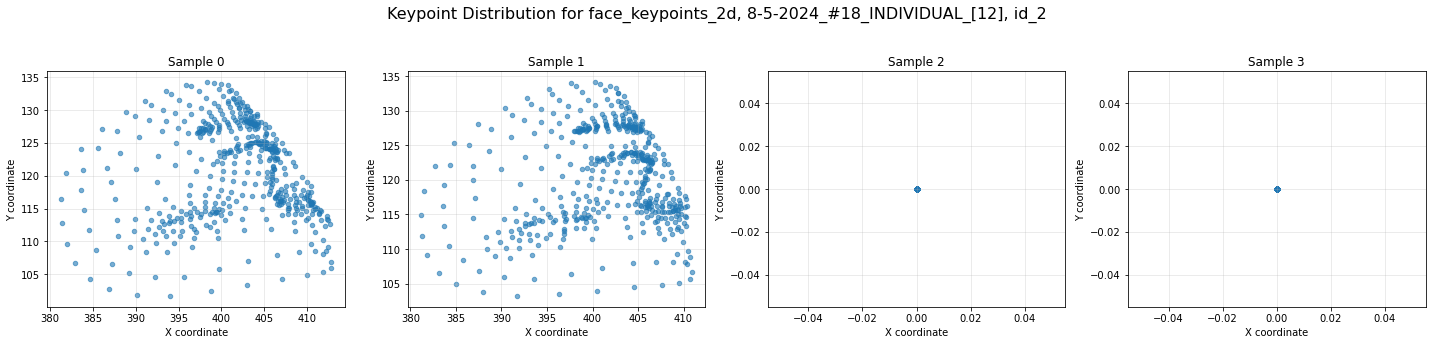

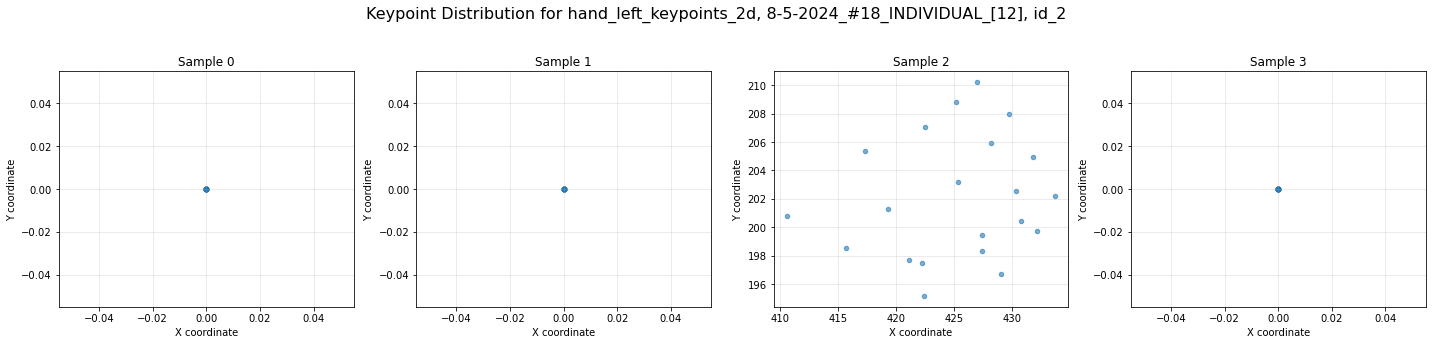

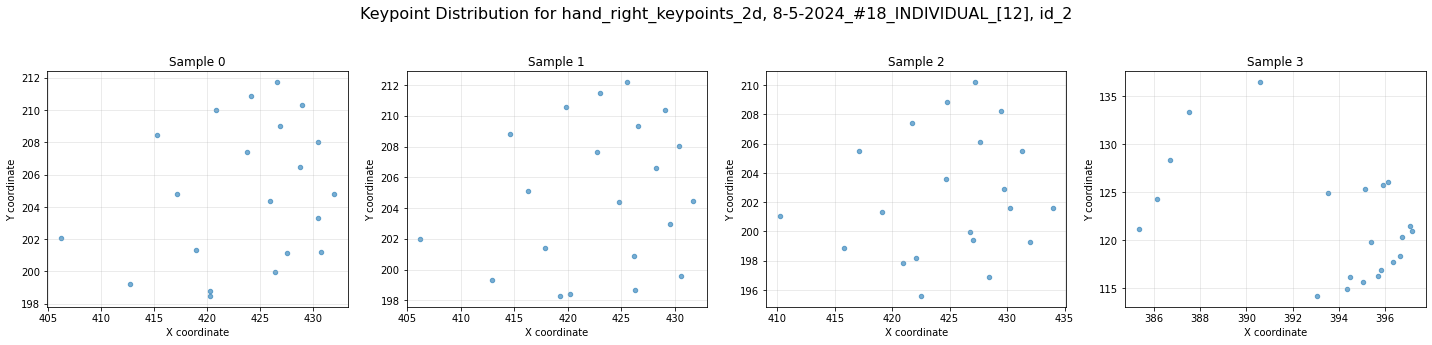

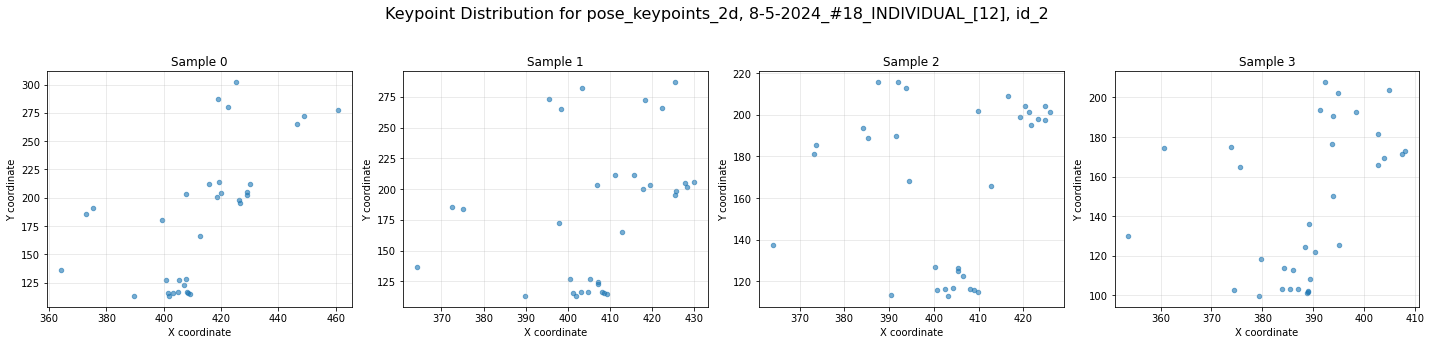

In [13]:
if __name__ == '__main__':
    keypoint_types = [
        'face_keypoints_2d',
        'hand_left_keypoints_2d',
        'hand_right_keypoints_2d',
        'pose_keypoints_2d'
    ]

    samples_to_plot = [0,1,2,3]

    for ktype in keypoint_types:
        kpts_array = extract_keypoints_as_array(data, ktype)
        visualize_keypoints_scatter(kpts_array, samples_to_plot, f"Keypoint Distribution for {ktype}, {directory}, id_{id}")

===================================================================================
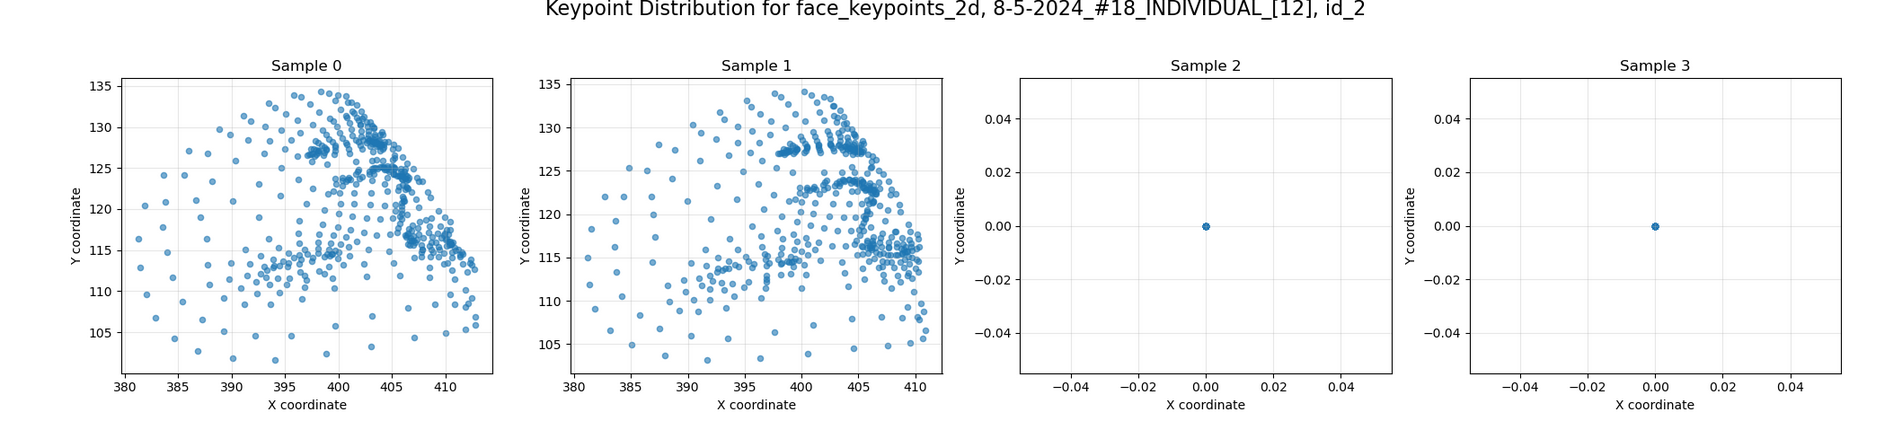